# Spaceship Titanic
The project inspects Spaceship Titanic Dataset from Kaggle. 

The primary objectives are to clean the data, perform exploratory data analysis, statistical analysis, and apply various machine learning models for target variable Transported prediction. 

Transported predictions will uploaded to Kaggle as a competition entry, performance goal is 79% accuracy (or more).

## Dataset
Dataset can be downloaded from [Kaggle](https://www.kaggle.com/competitions/spaceship-titanic/overview).

In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lazypredict.Supervised import LazyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline


pd.plotting.register_matplotlib_converters()
%matplotlib inline

%load_ext autoreload
%autoreload 2
from help_tool import help_tool


"""Setting graph parameters"""
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
continuous_features = ['Age', 'Group', 'Deck_num'] + amenities
category_features = ['HomePlanet', 'Destination', 'Deck', 'Group_Id']
binary_features = ['CryoSleep', 'VIP', 'Transported']

In [96]:
train = help_tool.csv_download(r'Archive\spaceship-titanic\train.csv')
help_tool.first_look(train)

Dataset has 8693 observations and 14 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
PassengerId,object,0,0.00
HomePlanet,object,201,2.30
CryoSleep,object,217,2.50
Cabin,object,199,2.30
Destination,object,182,2.10
Age,float64,179,2.10
VIP,object,203,2.30
RoomService,float64,181,2.10
FoodCourt,float64,183,2.10
ShoppingMall,float64,208,2.40


In [97]:
train = help_tool.cleaning(train, amenities)

train.drop(columns=['PassengerId'], inplace=True)

train['Transported'] = train['Transported'].astype(int)

# Feature engineering implementation
Checking if feature engineering enhanced or reduced the accuracy of simple models. After this check, the selected feature set will be used further.

## Simple Models with amenities_per_person
In EDA, new features have been created - that describe amenities_per_person. These features showed great promise in Mutual Information scores, where they scored higher than their non-engineered counterparts.

In [98]:
for feature in amenities:
    train[f'Avg_{feature}'] = train.groupby(['Group', 'GroupSize'])[
        feature].transform('mean')


amenities_per_person = ['Avg_RoomService', 'Avg_FoodCourt', 'Avg_ShoppingMall',
                        'Avg_Spa', 'Avg_VRDeck']

train[amenities_per_person] = np.log1p(train[amenities_per_person])
train.drop(columns='Group', inplace=True)

amenities_per_person is entered as training and validation dataset.

In [99]:
X = train.drop(columns=['Transported'] + amenities)
y = train['Transported']


(X_train, X_validation, y_train, y_validation) = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_validation, y_train, y_validation)

 97%|█████████▋| 28/29 [00:22<00:00,  1.15it/s]

[LightGBM] [Info] Number of positive: 3065, number of negative: 3020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 6085, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503698 -> initscore=0.014791
[LightGBM] [Info] Start training from score 0.014791


100%|██████████| 29/29 [00:22<00:00,  1.29it/s]


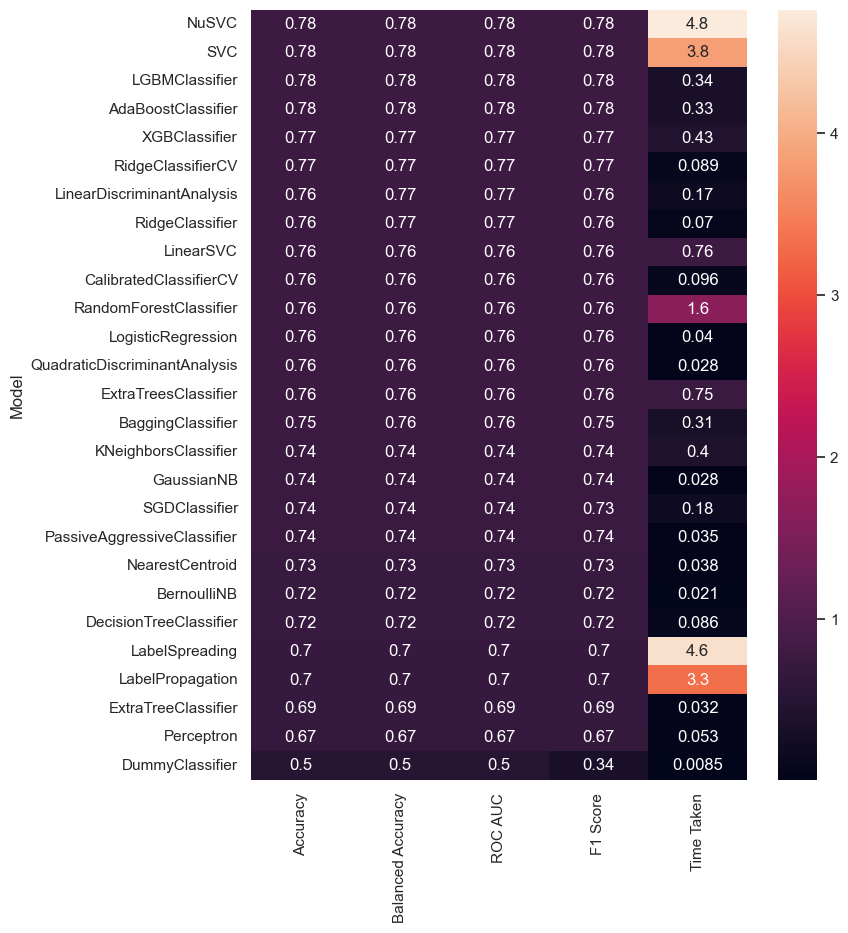

In [100]:
plt.figure(figsize=(8, 10))

sns.heatmap(models, annot=True)
plt.show()

Conclusion: 
* Simple models have 78% best accuracy when using amenities_per_person.

## Simple Models without feature engineering
Despite showing great promise, engineered features will be checked against their unchanged counterparts.

In [101]:
X = train.drop(columns=['Transported'] + amenities_per_person)
y = train['Transported']


(X_train, X_validation, y_train, y_validation) = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_validation, y_train, y_validation)

100%|██████████| 29/29 [00:16<00:00,  1.79it/s]

[LightGBM] [Info] Number of positive: 3065, number of negative: 3020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 6085, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503698 -> initscore=0.014791
[LightGBM] [Info] Start training from score 0.014791


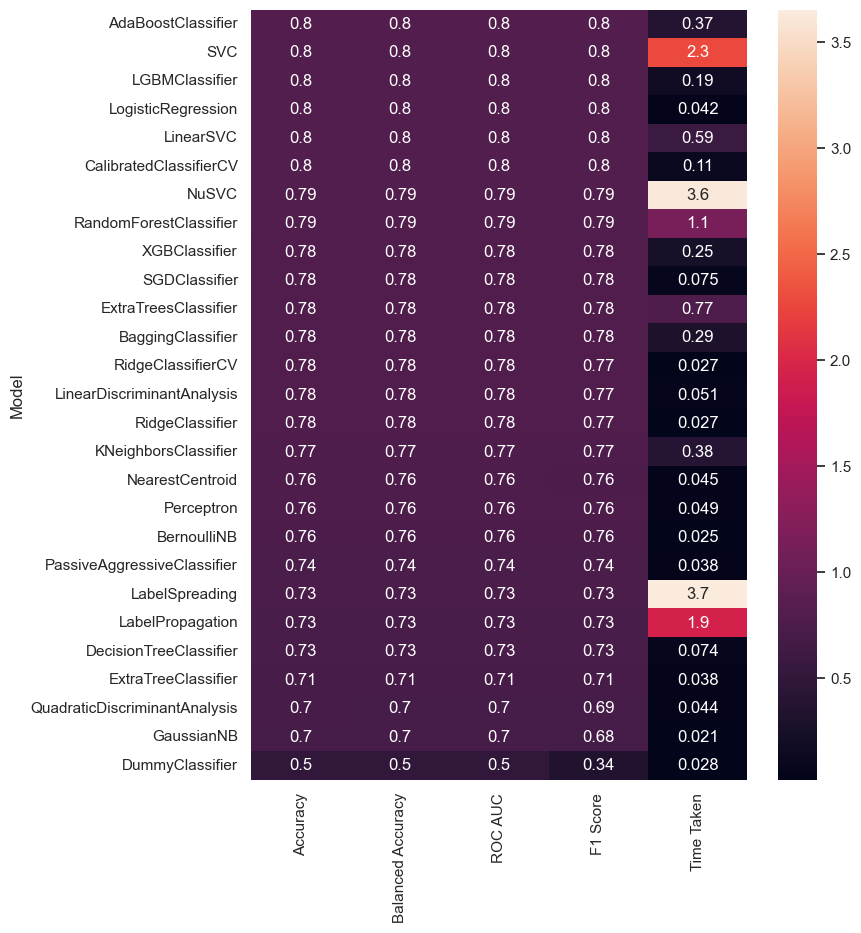

In [102]:
plt.figure(figsize=(8, 10))

sns.heatmap(models, annot=True)
plt.show()

Conclusion: 
* Simple models have 80% best accuracy when not using amenities_per_person.

Non-engineered features will be used going forward.

# Model Tuning
Selected models will be hyper parameter and threshold tuned

## Hyperparameted  Tuning
Hyperparameter search is done using Pipeline and RandomizedSearchCV. Different models require different data preparation (i.e. Logistic Regression and KNN requires scaling, while Tree based models require sorting), but because a Pipeline is used, all models are being fed the same StandardScaled data.

After best parameters and models are storred in memory.

In [103]:
classifiers = {
    'Radial SVM': (SVC(probability=False), {
        'clf__C': [0.01, 10, 100, 1000],
        'clf__gamma': [0.01, 10, 100, 1000]
    }),

    'Linear SVM': (LinearSVC(), {
        'clf__C': [0.01, 10, 100, 1000],
        'clf__penalty': ['l2']
    }),

    'Decision Tree': (DecisionTreeClassifier(), {
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [None, 5, 10, 15, 20],
        'clf__min_samples_split': [2, 5, 10, 20, 50, 100],
        'clf__min_samples_leaf': [1, 2, 4]
    }),
    'Random Forest': (RandomForestClassifier(), {
        'clf__n_estimators': list(range(100, 1000, 10)),
        'clf__max_depth': list(range(1, 110, 10)),
        'clf__max_features': ['sqrt', 'log2'],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__bootstrap': [True, False]
    }),
    'KNN': (KNeighborsClassifier(), {
        'clf__n_neighbors': list(range(2, 21)),
        'clf__weights': ['uniform', 'distance'],
        'clf__p': [1, 2],
        'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }),
    'Naive Bayes': (GaussianNB(), {
        'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    }),
    'XGBoost': (XGBClassifier(), {
        'clf__max_depth': [3, 5, 7],
        'clf__learning_rate': [0.1, 0.01],
        'clf__n_estimators': [100, 200]
    }),
    'LightGBM': (LGBMClassifier(), {
        'clf__boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
        'clf__num_leaves': [20, 30, 40, 50],
        'clf__learning_rate': [0.1, 0.01],
        'clf__n_estimators': [100, 200, 300],
        'clf__force_col_wise': [True]
    }),
    'Logistic Regression': (LogisticRegression(), {
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.01, 0.1, 1, 10, 100]
    })
}

# Loop over each model
for model_name, (model, param_dist) in classifiers.items():
    pipeline = Pipeline([('scaler', StandardScaler()), ('clf', model)])

    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=10,
        cv=10,
        random_state=42,
        scoring='accuracy'
    )

    random_search.fit(X_train, y_train)

    best_clf = random_search.best_estimator_
    best_params = random_search.best_params_

    # Store best model and parameters
    if model_name == 'Radial SVM':
        svm = best_clf
        svm_param = best_params
    elif model_name == 'Linear SVM':
        lsvm = best_clf
        lsvm_param = best_params
    elif model_name == 'Decision Tree':
        dtree = best_clf
        dtree_param = best_params
    elif model_name == 'Random Forest':
        rforest = best_clf
        rforest_param = best_params
    elif model_name == 'KNN':
        knn = best_clf
        knn_param = best_params
    elif model_name == 'Naive Bayes':
        nb = best_clf
        nb_param = best_params
    elif model_name == 'XGBoost':
        xgb = best_clf
        xgb_param = best_params
    elif model_name == 'LightGBM':
        lgbm = best_clf
        lgbm_params = best_params
    elif model_name == 'Logistic Regression':
        logreg = best_clf
        logreg_params = best_params

    print(f"Best Hyperparameters for {model_name}: {best_params}")

    accuracy_train = accuracy_score(y_train, best_clf.predict(X_train))
    accuracy_validation = accuracy_score(
        y_validation, best_clf.predict(X_validation))

    print(
        f"Validation Accuracy for {model_name}: {accuracy_train:.2f}/{accuracy_validation:.2f}")

Best Hyperparameters for Radial SVM: {'clf__gamma': 0.01, 'clf__C': 100}
Validation Accuracy for Radial SVM: 0.81/0.80
Best Hyperparameters for Linear SVM: {'clf__penalty': 'l2', 'clf__C': 10}
Validation Accuracy for Linear SVM: 0.79/0.80
Best Hyperparameters for Decision Tree: {'clf__min_samples_split': 100, 'clf__min_samples_leaf': 1, 'clf__max_depth': 5, 'clf__criterion': 'entropy'}
Validation Accuracy for Decision Tree: 0.78/0.77
Best Hyperparameters for Random Forest: {'clf__n_estimators': 550, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_features': 'log2', 'clf__max_depth': 91, 'clf__bootstrap': True}
Validation Accuracy for Random Forest: 0.95/0.80
Best Hyperparameters for KNN: {'clf__weights': 'uniform', 'clf__p': 1, 'clf__n_neighbors': 9, 'clf__algorithm': 'kd_tree'}
Validation Accuracy for KNN: 0.83/0.78
Best Hyperparameters for Naive Bayes: {'clf__var_smoothing': 1e-09}
Validation Accuracy for Naive Bayes: 0.71/0.70
Best Hyperparameters for XGBoost: {'c

Some models have the same accuracy after hyperparameter tuning, but some have 1% enhance (i.e. KNN). Hyperparameter Tuning is showing less impact than Feature Engineering.

## Threshold Tuning
After finding the best Hyperparameters, Optimal Thresholds will be found and stored in a dataframe.

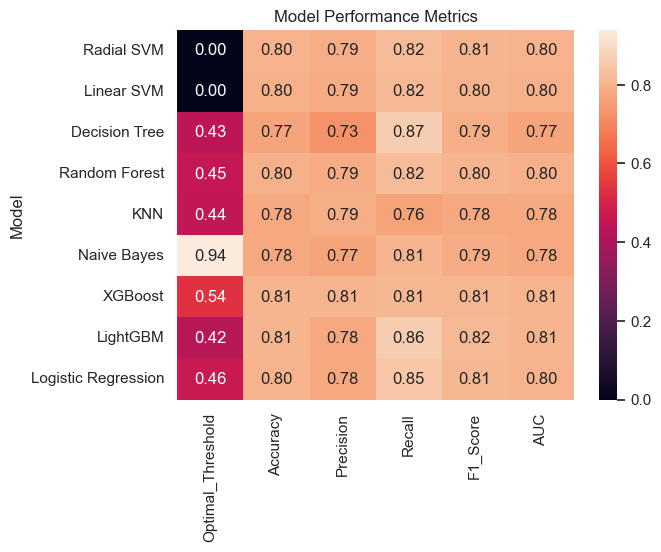

In [104]:
classifier_models = {
    'svm': {'model': svm, 'label': 'Radial SVM'},
    'lsvm': {'model': lsvm, 'label': 'Linear SVM'},
    'dtree': {'model': dtree, 'label': 'Decision Tree'},
    'rforest': {'model': rforest, 'label': 'Random Forest'},
    'knn': {'model': knn, 'label': 'KNN'},
    'nb': {'model': nb, 'label': 'Naive Bayes'},
    'xgb': {'model': xgb, 'label': 'XGBoost'},
    'lgbm': {'model': lgbm, 'label': 'LightGBM'},
    'logreg': {'model': logreg, 'label': 'Logistic Regression'}
}

results = []

for name, model_info in classifier_models.items():
    model = model_info['model']
    label = model_info['label']

    # Create thresholds for decision threshold tuning
    thresholds = np.linspace(0, 1, 100)

    # Initialize variables to track best accuracy and threshold
    best_accuracy = 0
    optimal_threshold = 0

    y_proba = help_tool.predict_proba_available(model, X_validation)

    # Find optimal threshold based on accuracy
    for threshold in thresholds:
        y_pred = (y_proba > threshold).astype(int)
        accuracy = accuracy_score(y_validation, y_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            optimal_threshold = threshold

    # Use the optimal threshold to predict final labels
    y_pred_optimal = (y_proba > optimal_threshold).astype(int)

    results.append({'Model': label,
                    'Optimal_Threshold': optimal_threshold,
                    'Accuracy': accuracy_score(y_validation, y_pred_optimal),
                    'Precision': precision_score(y_validation, y_pred_optimal),
                    'Recall': recall_score(y_validation, y_pred_optimal),
                    'F1_Score': f1_score(y_validation, y_pred_optimal),
                    'AUC': roc_auc_score(y_validation, y_pred_optimal)
                    })

model_threshol_search = pd.DataFrame(results)


sns.heatmap(model_threshol_search.set_index(
    'Model'), annot=True, fmt=".2f")
plt.title('Model Performance Metrics')
plt.show()

In [105]:
thresholds_df = help_tool.feature_transpose(
    model_threshol_search, ['Model', 'Optimal_Threshold'])
thresholds_df

,Model,Radial SVM,Linear SVM,Decision Tree,Random Forest,KNN,Naive Bayes,XGBoost,LightGBM,Logistic Regression
1,Optimal_Threshold,0.00,0.00,0.43,0.45,0.44,0.94,0.54,0.42,0.46


After Threshold Tunning, best models are XGBoost and LightGBM, with 81% accuracy. 

# Cross Validation
Cross Validation will be performed on all the models. Making sure the good results are not just chance.

In [106]:
def cross_val_thresholds(fold, X, y, thresholds_df, classifiers):
    """ Cross validation with threshold adjustments and feature scaling """
    kf = KFold(n_splits=fold, shuffle=True, random_state=42)

    # Initialize lists to store metric scores and confusion matrices
    metric_scores = {metric: {clf_name: [] for clf_name in classifiers.keys()}
                     for metric in ['accuracy', 'precision', 'recall', 'f1']}
    confusion_matrices = {clf_name: np.zeros(
        (2, 2)) for clf_name in classifiers.keys()}

    for train_index, val_index in kf.split(X):
        X_train_i, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train_i, y_val = y.iloc[train_index], y.iloc[val_index]

        # Initialize and fit StandardScaler on training data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_i)
        X_val_scaled = scaler.transform(X_val)

        for clf_name, clf in classifiers.items():
            clf.fit(X_train_scaled, y_train_i)

            # Threshold update
            scores = help_tool.predict_proba_available(clf, X_val_scaled)

            optimal_threshold = thresholds_df[clf_name].iloc[0]
            y_pred = (scores > optimal_threshold).astype(int)

            # Calculate metrics
            metric_scores['accuracy'][clf_name].append(
                accuracy_score(y_val, y_pred))
            metric_scores['precision'][clf_name].append(
                precision_score(y_val, y_pred))
            metric_scores['recall'][clf_name].append(
                recall_score(y_val, y_pred))
            metric_scores['f1'][clf_name].append(f1_score(y_val, y_pred))

            # Compute confusion matrix
            cm = confusion_matrix(y_val, y_pred)
            confusion_matrices[clf_name] += cm

    # Calculate average scores
    avg_metric_scores = {metric: {clf_name: np.mean(scores) for clf_name, scores in clf_scores.items()}
                         for metric, clf_scores in metric_scores.items()}

    # Average confusion matrices
    avg_confusion_matrices = {
        clf_name: matrix / fold for clf_name, matrix in confusion_matrices.items()}

    cv_results = []
    for clf_name, scores in avg_metric_scores['accuracy'].items():
        cv_results.append({
            'Classifier': classifiers[clf_name].__class__.__name__,
            'CV Mean Accuracy': np.mean(scores),
            'CV Mean Precision': np.mean(avg_metric_scores['precision'][clf_name]),
            'CV Mean Recall': np.mean(avg_metric_scores['recall'][clf_name]),
            'CV Mean F1': np.mean(avg_metric_scores['f1'][clf_name]),
            'Confusion Matrix': avg_confusion_matrices[clf_name]
        })

    model_info = pd.DataFrame(cv_results)
    return model_info

[LightGBM] [Info] Number of positive: 2916, number of negative: 2864
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 5780, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504498 -> initscore=0.017994
[LightGBM] [Info] Start training from score 0.017994
[LightGBM] [Info] Number of positive: 2900, number of negative: 2880
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 5780, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501730 -> initscore=0.006920
[LightGBM] [Info] Start training from score 0.006920
[LightGBM] [Info] Number of positive: 2901, number of negative: 2879
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 5780, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501903 -> initscore=0.007612
[LightGBM] [Info] Start training from score 0.007612
[LightGBM] [Info] N

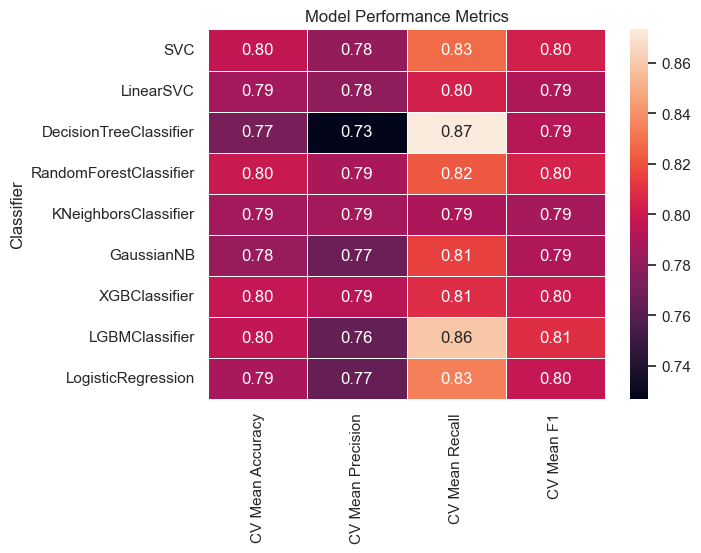

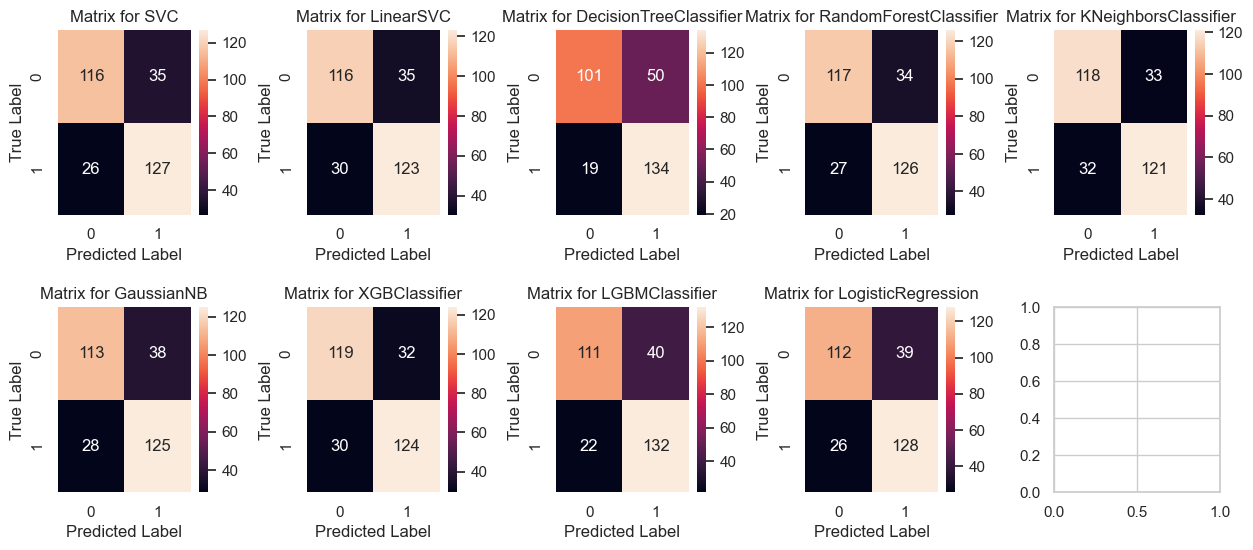

In [107]:
classifiers = {
    'Radial SVM': SVC(
        kernel='rbf',
        probability=False,
        C=svm_param['clf__C'],
        gamma=svm_param['clf__gamma'],
        random_state=42
    ),

    'Linear SVM': LinearSVC(
        C=lsvm_param['clf__C'],
        penalty=lsvm_param['clf__penalty'],
        random_state=42
    ),

    'Decision Tree': DecisionTreeClassifier(
        min_samples_split=dtree_param['clf__min_samples_split'],
        min_samples_leaf=dtree_param['clf__min_samples_leaf'],
        max_depth=dtree_param['clf__max_depth'],
        criterion=dtree_param['clf__criterion'],
        random_state=42
    ),

    'Random Forest': RandomForestClassifier(
        n_estimators=rforest_param['clf__n_estimators'],
        min_samples_split=rforest_param['clf__min_samples_split'],
        min_samples_leaf=rforest_param['clf__min_samples_leaf'],
        max_features=rforest_param['clf__max_features'],
        max_depth=rforest_param['clf__max_depth'],
        bootstrap=rforest_param['clf__bootstrap'],
        random_state=42
    ),
    'KNN': KNeighborsClassifier(
        weights=knn_param['clf__weights'],
        p=knn_param['clf__p'],
        n_neighbors=knn_param['clf__n_neighbors'],
        algorithm=knn_param['clf__algorithm']
    ),

    'Naive Bayes': GaussianNB(
        var_smoothing=nb_param['clf__var_smoothing']
    ),

    'XGBoost': XGBClassifier(
        max_depth=xgb_param['clf__max_depth'],
        learning_rate=xgb_param['clf__learning_rate'],
        n_estimators=xgb_param['clf__n_estimators'],
        random_state=42
    ),

    'LightGBM': LGBMClassifier(
        boosting_type=lgbm_params['clf__boosting_type'],
        num_leaves=lgbm_params['clf__num_leaves'],
        learning_rate=lgbm_params['clf__learning_rate'],
        n_estimators=lgbm_params['clf__n_estimators'],
        force_col_wise=lgbm_params['clf__force_col_wise'],
        random_state=42
    ),

    'Logistic Regression': LogisticRegression(
        penalty=logreg_params['clf__penalty'],
        C=logreg_params['clf__C'],
        random_state=42
    )
}


def cross_val_plots(fold, X, y, thresholds_df, classifiers):

    model_info = cross_val_thresholds(
        fold, X, y, thresholds_df, classifiers)

    help_tool.cross_validation_param(
        model_info.drop('Confusion Matrix', axis=1))
    help_tool.cross_validation_confusion_matrix(model_info)


cross_val_plots(20, X_train, y_train, thresholds_df, classifiers)

* Best models (XGBoost and LightGBM), have accuracy 80%, which is a decrease of 1%, but still good.
* DecisionTree, KNN and GaussianNB seam to be the worst on their own. 

# Voting
Voting classifier will be constructed in hopes of improving performance. Different models are selected:
* Decision Tree - lowest False Negatives
* Radial SVM - also low False Negatives
* XGBoost - lowest False positives

In [108]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_validation)


estimators = [
    ('Decision Tree', dtree),
    ('Radial SVM', svm),
    ('XGBoost', xgb)
]

In [113]:
voting_clf_hard = VotingClassifier(estimators=estimators, voting='hard')
voting_clf_hard.fit(X_train_scaled, y_train)

y_pred = voting_clf_hard.predict(X_val_scaled)

Accuracy: 0.80
Precision: 0.78
Recall: 0.85


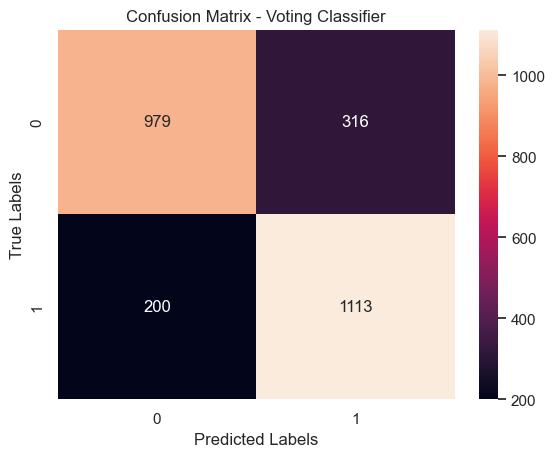

In [114]:
help_tool.model_confusion_matrix(
    voting_clf_hard, X_val_scaled, y_validation, y_pred)

Hard Voting has similar accuracy as LightGBM and is not an improvement.

# Model explanability
LightGBM was chosen for explainability, as it had the best scores out of all of the models. Sub-sample of 100 is used instead of the whole set, for time saving.

In [121]:
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_validation.columns)

model = lgbm['clf']


background_sample = shap.sample(X_validation, 100)



explainer = shap.Explainer(model)

shap_values = explainer.shap_values(background_sample)

Shap values summary shows Spa and CryoSleep having impact on models predictions. Before model fitting, only CryoSleep was expected to have a high impact.

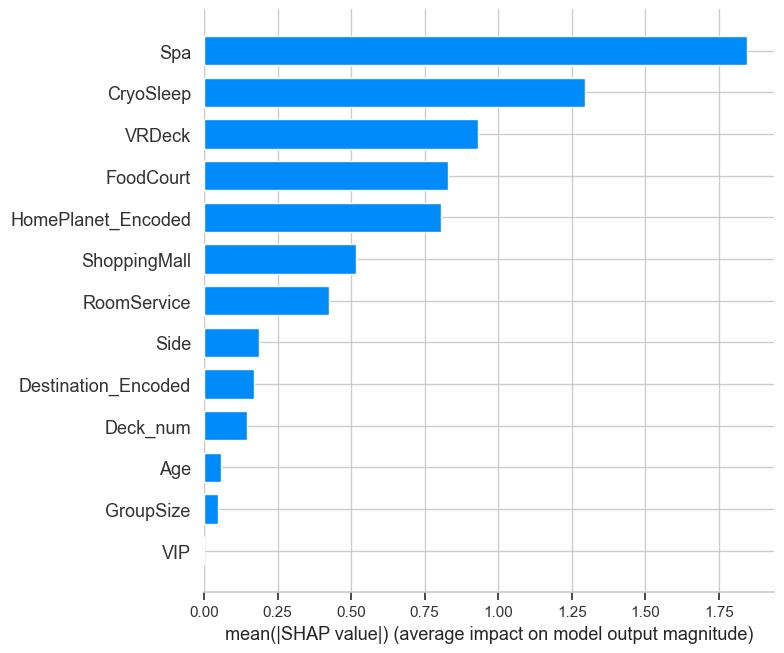

In [119]:
shap.summary_plot(shap_values, features=background_sample, plot_type='bar')
plt.show()

Having Shap value of purely Low or High Feature value would suggest that feature is either useful of distracting for the model. However, these values are mixed - especially Spa, who has a negative impact, both High and Low. This could be a good candidate for Principal Component Analysis - for separating the useful and distracting parts.

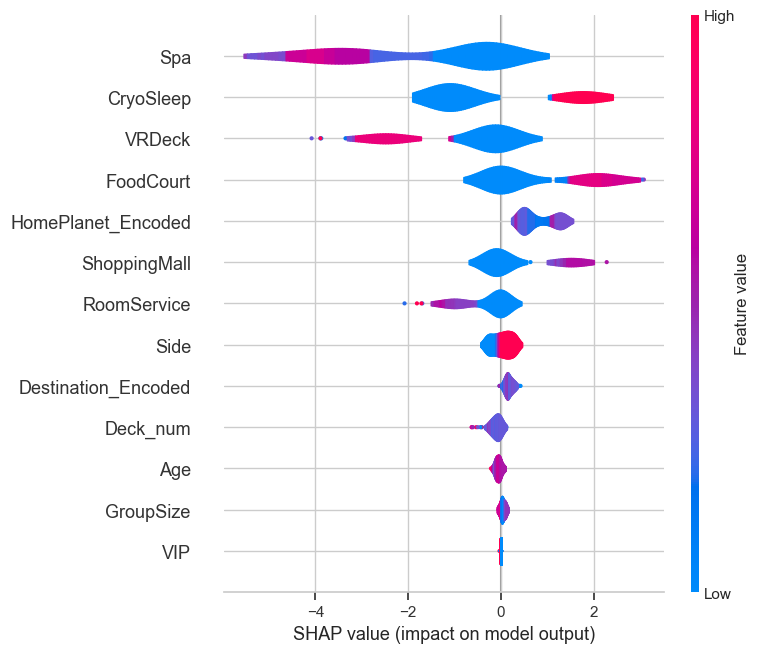

In [ ]:
shap.summary_plot(shap_values, plot_type='violin', features=background_sample)

* Destination_Encoded 2 is 55 Cancri e
* HomePlanet_Encoded 1 is Earth

Analysing Force plot, we can see that Transported is increased by:
* Going to 55 Cancri e 
* Traveling from Earth
* Not CryoSleeping

Decreases:
* Not using the Spa
* Being on Side S
* Hanging out at the VRDeck and ShoppingMall.

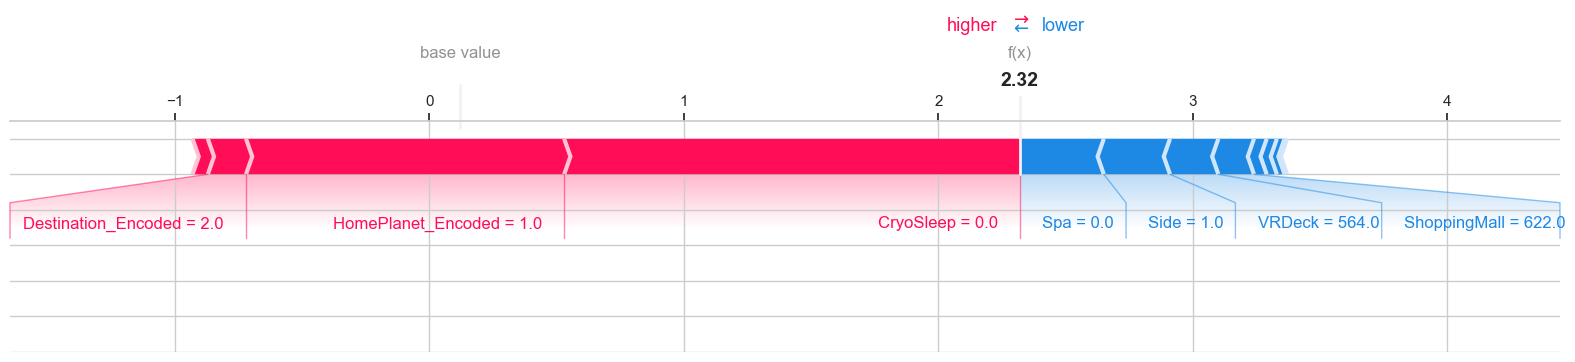

In [ ]:
shap.plots.force(explainer.expected_value.round(2), shap_values[1].round(
    2), background_sample.iloc[0, :].round(2), matplotlib=True)

Overall, amenities has a big impact on the model. Mostly confusing effect.

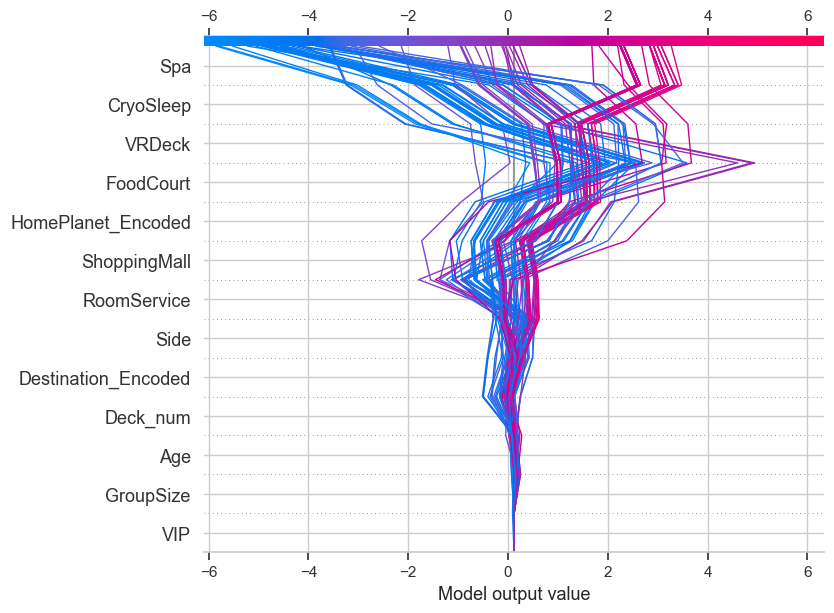

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values,
                   background_sample.columns)

# Output and Kaggle test set
Submitting the best models to Kaggle. Both Voting and LightGBM has performed the best with 80% on validation data.

In [123]:
test = help_tool.csv_download(r'Archive\spaceship-titanic\test.csv')
test = help_tool.cleaning(test, amenities)

# Prepare for output
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']

test.drop(columns=['PassengerId', 'Group'], inplace=True)

In [125]:
def kaggle_submission_file(model):

    # Make predictions
    y_pred = model.predict(scaler.transform(test))
    submission['Transported'] = y_pred
    submission['Transported'] = submission['Transported'].replace(
        {1: True, 0: False})

    # Export output
    submission.to_csv(r'Archive\spaceship-titanic\output.csv', index=False)

After submitting, Voting classifier had 0.79822 accuracy score.

In [ ]:
kaggle_submission_file(voting_clf_hard)

LightGBM had 0.79915 accuracy.

In [126]:
kaggle_submission_file(lgbm['clf'])

# Conclusion
* In this work, 79% accuracy was achieved with Voting and LightGBM models.
* New features have been created, but it decreased model performance. Best performance was showed with pre-existing set of features.
* Shap values show confused model, amenities features having both low and high impact at once. Future work should explore Principle Component Analysis, for better useful information extraction.